In [1]:
#Importing libraries and tools
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install -q kaggle

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [5]:
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset

In [6]:
#Getting the directories for the training and testing data
train_dir = '/content/brain_tumor_dataset/Testing'
test_dir = '/content/brain_tumor_dataset/Training'

#Load and shuffle the training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
      for image in os.listdir(os.path.join(train_dir, label)):
            train_paths.append((os.path.join(train_dir, label, image), label))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

#Load and shuffle the testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
      for image in os.listdir(os.path.join(test_dir, label)):
            test_paths.append((os.path.join(test_dir, label, image), label))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

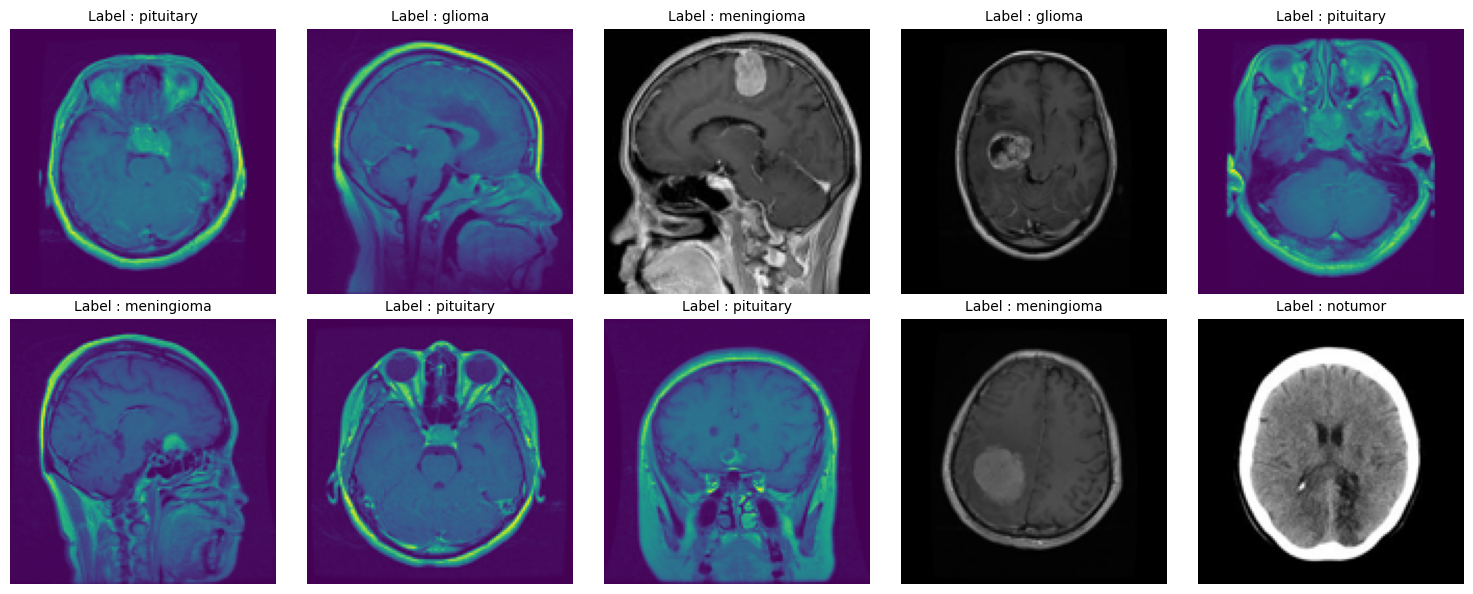

In [12]:
random_indices = random.sample(range(len(train_paths)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, index in enumerate(random_indices):
    image_path = train_paths[index][0]  # assuming train_paths = [(path, label), ...]
    img = Image.open(image_path).resize((128, 128))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label : {train_labels[index]}", fontsize = 10)

plt.tight_layout()
plt.show()


#**Image Preprocessing**

In [14]:
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

def open_images(paths):
  image = []
  for path in paths:
    img = load_img(path,target_size=(IMAGE_SIZE,IMAGE_SIZE))
    img = augment_image(img)
    image.append(img)
  return np.array(image)

def encode_label(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in unique_labels]
  return encoded

def data_gen(paths,labels,batch_size=12,epochs=1):
  for _ in range(epochs):
    for i in range(0,len(paths),batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = encode_label(labels[i:i+batch_size])
      yield batch_images,batch_labels

#**Model**